In [2]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf


### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [4]:
base_path = 'Dataset/OIV5'
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(os.path.join(base_path, images_boxable_fname))
#print(images_boxable.columns)
images_boxable.columns=['image_name', 'Subset', 'image_url', 'OriginalLandingURL', 'License',
       'AuthorProfileURL', 'Author', 'Title', 'OriginalSize', 'OriginalMD5',
       'Thumbnail300KURL', 'Rotation']
images_boxable.head()

,image_name,Subset,image_url,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [7]:
annotations_bbox = pd.read_csv(os.path.join(base_path, annotations_bbox_fname))
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [8]:
class_descriptions = pd.read_csv(os.path.join(base_path, class_descriptions_fname),names=["name","class"])
class_descriptions.head()

,name,class
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


### Show one image by using these three tables

In [9]:
print('length of the images_boxable: %d' %(len(images_boxable)) )
print('First image in images_boxable👇')
img_name = images_boxable['image_name'][100]
img_url = images_boxable['image_url'][100]
print('\t image_name: %s' % (img_name))
print('\t img_url: %s' % (img_url))
print('')
print('length of the annotations_bbox: %d' %(len(annotations_bbox)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('length of the class_descriptions: %d' % (len(class_descriptions)-1))
img = io.imread(img_url)

length of the images_boxable: 1743042
First image in images_boxable👇
	 image_name: 2ec86cd1f7a6400c
	 img_url: https://c5.staticflickr.com/4/3080/2395003504_721d053dc5_o.jpg

length of the annotations_bbox: 14610229
The number of bounding boxes are larger than number of images.

length of the class_descriptions: 600


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>

(900, 1200, 3)


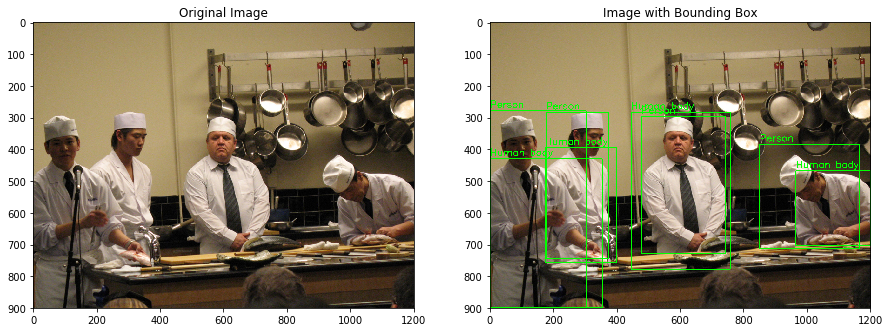

In [7]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
img_id = img_name[:16]
bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = row['XMin']
    xmax = row['XMax']
    ymin = row['YMin']
    ymax = row['YMax']
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    label_name = row['LabelName']
    class_series = class_descriptions[class_descriptions['name']==label_name]
    class_name = class_series['class'].values[0]
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,class_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

In [8]:
# io.imsave(os.path.join(base_path,'Person')+'/1.jpg', img)

As we can see, by using these three tables, the image with bounding box could be drawn

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car.

The dataset from [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/download.html) is too large for me. So I just extract 1000 images for each class from the whole dataset.

In [19]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions['class']=='Person']
phone_pd = class_descriptions[class_descriptions['class']=='Mobile phone']
car_pd = class_descriptions[class_descriptions['class']=='Car']
guitar_pd = class_descriptions[class_descriptions['class']=='Guitar']

label_name_person = person_pd['name'].values[0]
label_name_phone = phone_pd['name'].values[0]
label_name_car = car_pd['name'].values[0]
label_name_guitar = guitar_pd['name'].values[0]

In [20]:
print(person_pd)
print(phone_pd)
print(car_pd)
print(guitar_pd)

         name   class
68  /m/01g317  Person
         name         class
312  /m/050k8  Mobile phone
        name class
570  /m/0k4j   Car
         name   class
218  /m/0342h  Guitar


**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [21]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]
guitar_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_guitar]

In [22]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
print('There are %d guitars in the dataset' %(len(guitar_bbox)))

person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']
guitar_img_id = guitar_bbox['ImageID']

There are 1034721 persons in the dataset
There are 6365 phones in the dataset
There are 248075 cars in the dataset
There are 25896 guitars in the dataset


In [23]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
guitar_img_id = np.unique(guitar_img_id)

print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))
print('There are %d images which contain guitar' % (len(guitar_img_id)))

There are 248384 images which contain persons
There are 4312 images which contain phones
There are 89465 images which contain cars
There are 17671 images which contain guitar


We just randomly pick 1000 images in here.

In [24]:
# Shuffle the ids and pick the first 1000 ids
copy_person_id = person_img_id.copy()
random.seed(1)
random.shuffle(copy_person_id)

copy_phone_id = phone_img_id.copy()
random.seed(1)
random.shuffle(copy_phone_id)

copy_car_id = car_img_id.copy()
random.seed(1)
random.shuffle(copy_car_id)

copy_guitar_id = guitar_img_id.copy()
random.seed(1)
random.shuffle(copy_guitar_id)

n = 1000
subperson_img_id = copy_person_id[:n]
subphone_img_id = copy_phone_id[:n]
subcar_img_id = copy_car_id[:n]
subguitar_img_id = copy_guitar_id[:n]

In [25]:
print(subperson_img_id[10])
print(subphone_img_id[10])
print(subcar_img_id[10])
print(subguitar_img_id[10])

0d38657e9e419712
8e5cb5c704a1daed
faf07faa862b9fc8
d792244aff663f97


In [26]:
# This might takes a while to search all these urls
subperson_img_url = [images_boxable[images_boxable['image_name']==name] for name in subperson_img_id]
subphone_img_url = [images_boxable[images_boxable['image_name']==name] for name in subphone_img_id]
subcar_img_url = [images_boxable[images_boxable['image_name']==name] for name in subcar_img_id]
subguitar_img_url = [images_boxable[images_boxable['image_name']==name] for name in subguitar_img_id]

In [27]:
subperson_img_id

array(['1a76122aab7176d8', '5accc0a51f39559f', 'f607867752dd80e9',
       '47df981ba82e224c', 'aff1b59bccb0f6cb', '493451d242a4db07',
       '52c3df5c80e17b7d', 'd7f6bd8eaaa895e8', '073af2b33d6dae8d',
       '93b47a2b2ba54ff0', '0d38657e9e419712', '571c73891600861d',
       'eaa31ab809d72b59', 'bb3e85963dc57b37', 'cba9c87b13a7f229',
       '25762b3bca3372c0', '04bb2ce5401f9adc', 'b321500f1e945322',
       '0eff9cc4da96bb03', '75cedc4e3e41ceda', '4ec6c0903971f4c4',
       '314564d99582b4a3', 'c0e74c2aae1c7e9a', 'fcaa9c7e1b9247ff',
       'fba269c883060007', 'ed9d7938ba998309', '9a5a186f3de76df8',
       '808ecfbdd6950dc8', 'b6d79eedeee65ce8', '09debf2a4b0e7c6b',
       '8dd6912439a4149c', '0597b56c8817d453', 'ca9955980b9b6897',
       'c0969e30fa49150f', '66745d8411ae98c9', '2e330834aff8a4de',
       '3c8567cfe0187c43', '2df752256cd41bf5', '1b50ee203ab8062e',
       '4508f24f36262e3b', '29b7026b6c1d27a0', 'd51eab0318c32901',
       '75ce19dae014af08', '8af61572eb78369e', '6964c146bf4b95

In [28]:
subperson_img_url

[               image_name Subset  \
 1332065  1a76122aab7176d8  train   
 
                                                  image_url  \
 1332065  https://c1.staticflickr.com/9/8683/15870199465...   
 
                                         OriginalLandingURL  \
 1332065  https://www.flickr.com/photos/airresources/158...   
 
                                               License  \
 1332065  https://creativecommons.org/licenses/by/2.0/   
 
                                     AuthorProfileURL  \
 1332065  https://www.flickr.com/people/airresources/   
 
                                  Author     Title  OriginalSize  \
 1332065  California Air Resources Board  IMG_0362       6182333   
 
                       OriginalMD5  \
 1332065  xuims+T3YIUcNoJV4cv6uw==   
 
                                           Thumbnail300KURL  Rotation  
 1332065  https://c8.staticflickr.com/9/8683/15870199465...       0.0  ,
                image_name Subset  \
 1385541  5accc0a51f39559f  train   

In [29]:
subperson_pd = pd.DataFrame()
subphone_pd = pd.DataFrame()
subcar_pd = pd.DataFrame()
subguitar_pd = pd.DataFrame()

for i in range(len(subperson_img_url)):
    subperson_pd = subperson_pd.append(subperson_img_url[i], ignore_index = True)
    subphone_pd = subphone_pd.append(subphone_img_url[i], ignore_index = True)
    subcar_pd = subcar_pd.append(subcar_img_url[i], ignore_index = True)
    subguitar_pd = subguitar_pd.append(subguitar_img_url[i], ignore_index = True)

subperson_pd.to_csv(os.path.join(base_path, 'subperson_img_url.csv'))
subphone_pd.to_csv(os.path.join(base_path, 'subphone_img_url.csv'))
subcar_pd.to_csv(os.path.join(base_path, 'subcar_img_url.csv'))
subguitar_pd.to_csv(os.path.join(base_path, 'subguitar_img_url.csv'))

In [30]:
subperson_img_url = [url['image_url'].values[0] for url in subperson_img_url]
subphone_img_url = [url['image_url'].values[0] for url in subphone_img_url]
subcar_img_url = [url['image_url'].values[0] for url in subcar_img_url]
subguitar_img_url = [url['image_url'].values[0] for url in subguitar_img_url]

urls = [subperson_img_url, subphone_img_url, subcar_img_url, subguitar_img_url]

In [33]:
subperson_pd = pd.read_csv('Dataset/OIV5/subperson_img_url.csv')
subphone_pd = pd.read_csv('Dataset/OIV5/subphone_img_url.csv')
subcar_pd = pd.read_csv('Dataset/OIV5/subcar_img_url.csv')
subguitar_pd = pd.read_csv('Dataset/OIV5/subguitar_img_url.csv')


subperson_img_url = subperson_pd['image_url'].values
subphone_img_url = subphone_pd['image_url'].values
subcar_img_url = subcar_pd['image_url'].values
subguitar_img_url = subguitar_pd['image_url'].values


urls = [subperson_img_url, subphone_img_url, subcar_img_url, subguitar_img_url]

In [34]:
urls[0][743]

'https://farm6.staticflickr.com/7392/10899847623_f0b6861168_o.jpg'

In [36]:
saved_dirs = [os.path.join(base_path,'Person'),os.path.join(base_path,'Mobile phone'),os.path.join(base_path,'Car'),os.path.join(base_path,'Guitar')]

In [44]:
classes = ['Person', 'Mobile phone', 'Car', 'Guitar']

In [39]:
print(len(urls[0]))
print(urls[0][0])
print(saved_dirs)

1000
https://c1.staticflickr.com/9/8683/15870199465_ace3a06527_o.jpg
['Dataset/OIV5\\Person', 'Dataset/OIV5\\Mobile phone', 'Dataset/OIV5\\Car', 'Dataset/OIV5\\Guitar']


### Download images

In [46]:
from pathlib import Path

# Download images
for i in range(len(classes)):
    # Create the directory
    if os.path.exists(saved_dirs[i]):
        print ("File exist")
    else:
        print ("File not exist")
        os.mkdir(saved_dirs[i])
    saved_dir = saved_dirs[i]
    for url in urls[i]:
        # print(url)
        try:
            img = io.imread(url)
            saved_path = os.path.join(saved_dir, url[-20:])
            io.imsave(saved_path, img)
        except:
            pass

File exist
File not exist


C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 12. Skipping tag 36868
  " Skipping tag %s" % (size, len(data), tag))


File not exist


C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11796480 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2621440 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3145728 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\alire\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF dat

File not exist


### Prepare dataset format for faster rcnn code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [11]:
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')


In [53]:
import shutil
# Save images to train and test directory

#shutil.rmtree('./'+base_path+'/'+ 'train')
#shutil.rmtree(os.path.join(base_path, 'test'))



train_path = os.path.join(base_path, 'train')
os.mkdir(train_path)
test_path = os.path.join(base_path, 'test')
os.mkdir(test_path)

for i in range(len(classes)):
    
    all_imgs = os.listdir(os.path.join(base_path, classes[i]))
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.seed(1)
    random.shuffle(all_imgs)
    
    train_imgs = all_imgs[:800]
    test_imgs = all_imgs[800:]
    
    # Copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # Copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(os.path.join(base_path, classes[i]), test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Dataset/OIV5\\train'

In [12]:
print('number of training images: ', len(os.listdir(train_path))) # subtract one because there is one hidden file named '.DS_Store'
print('number of test images: ', len(os.listdir(test_path)))

number of training images:  3197
number of test images:  441


The expected number of training images and validation images should be 3x800 -> 2400 and 3x200 -> 600.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [40]:
img_name = train_imgs[0]
ttdf=images_boxable[images_boxable['image_url'].str.contains(img_name) == True]
#print(ttdf)
img_id=ttdf.iloc[0]['image_name']
print(img_id)

4033ca266eb672ad


In [46]:
label_names = [label_name_person, label_name_phone, label_name_car,label_name_guitar]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName', 'img_id'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    img_name = train_imgs[i]
    #img_id = img_name[0:16]
   
    ttdf=images_boxable[images_boxable['image_url'].str.contains(img_name) == True]
    img_id=ttdf.iloc[0]['image_name']
   
    sys.stdout.write('img_id ' + str(img_id) +' Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    #print(tmp_df.count)
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        sys.stdout.write('LabelName ' + str(labelName) + '\r')
        sys.stdout.flush()
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i],'img_id':img_id}, 
                                           ignore_index=True)

In [52]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName', 'img_id'])

# Find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    
    ttdf=images_boxable[images_boxable['image_url'].str.contains(img_name) == True]
    img_id=ttdf.iloc[0]['image_name']
    #img_id = img_name[0:16]
    
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i],'img_id':img_id}, 
                                           ignore_index=True)

In [53]:
train_df.to_csv(os.path.join(base_path, 'train.csv'))
test_df.to_csv(os.path.join(base_path, 'test.csv'))

### Write train.csv to annotation.txt

In [5]:
# print(train_df.head())
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

# For training
f= open(base_path + "/annotation.txt","w+")
for idx, row in train_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    img = cv2.imread((base_path + '/train/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = '.\\Dataset\\OIV5\\train'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    img_id = row['img_id']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className+ ',' + img_id + '\n')
f.close()

In [7]:
#print(test_df.head())
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# For test
f= open(base_path + "/test_annotation.txt","w+")
for idx, row in test_df.iterrows():
    sys.stdout.write(str(idx) + '\r')
    sys.stdout.flush()
    img = cv2.imread((base_path + '/test/' + row['FileName']))
    height, width = img.shape[:2]
    x1 = int(row['XMin'] * width)
    x2 = int(row['XMax'] * width)
    y1 = int(row['YMin'] * height)
    y2 = int(row['YMax'] * height)
    
    google_colab_file_path = '.\\Dataset\\OIV5\\test'
    fileName = os.path.join(google_colab_file_path, row['FileName'])
    className = row['ClassName']
    img_id = row['img_id']
    f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className+ ',' + img_id + '\n')
f.close()